In [1]:
import os 
import sys
from os.path import basename, dirname, join
import time

import numpy as np
import pandas as pd
import geopandas as gpd


import matplotlib.pyplot as plt
import matplotlib as mpl

from osgeo import gdal
import contextily as ctx



In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Stream_seepage/'
dat_dir = proj_dir+'Stream_level_data/'

sfr_dir = gwfm_dir+'/SFR_data/'

In [3]:
flopy_dir = doc_dir+'/GitHub/flopy/'
if flopy_dir not in sys.path:
    sys.path.append(flopy_dir)
# sys.path
import flopy 

from importlib import reload
# importlib.reload
reload(flopy)

<module 'flopy' from 'C:\\Users\\ajcalder\\Documents/GitHub/flopy\\flopy\\__init__.py'>

In [4]:
def gdf_bnds(gdf, ax):
    minx, miny, maxx, maxy = gdf.geometry.unary_union.bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

def get_nodes(locs):
    ''' Converts layer, row, column into model node number '''
    nodes = []
    for k, i, j in locs:
        nodes.append(k * m.dis.nrow * m.dis.ncol + i * m.dis.ncol + j)
    return nodes
 

In [7]:

loadpth = 'F:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage/'
model_ws = loadpth+'inset_oneto_denier'

m = flopy.modflow.Modflow.load('MF.nam', model_ws=model_ws, 
                                exe_name='mf-owhm', version='mfnwt') #, load_only = load_only)

In [8]:
nlay = m.dis.nlay
nrow = m.dis.nrow
ncol = m.dis.ncol

In [9]:
nper = m.dis.nper # number of months
# m.dis.nstp.array[1:] # number of steps
perlen = m.dis.perlen.array # days per period

strt_date = np.datetime64(m.start_datetime)
# strt_date = np.datetime64('1990-10-01')
end_date = strt_date + np.timedelta64(int(perlen.sum()-1),'D')


In [10]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
cbb = flopy.utils.CellBudgetFile(model_ws+'/MF.cbc')

times = hdobj.get_times()
# subtract 1 to have start of each period
dt_ref = pd.DataFrame(np.asarray(times), columns=['time']) 
dt_ref['timedelta'] = pd.to_timedelta(dt_ref.time, 'D').round('H')
dt_ref['dt'] = strt_date+dt_ref.timedelta
dt_ref['kstpkper'] = spd_stp
dt_ref[['kstp','kper']] = dt_ref.kstpkper.tolist()

## Identify locations for particle release

We are interested in identify whether particles recharged from the streambed and floodplain remain near the channel, return to the stream or exit the system through pumping, ET or lateral boundaries.

In [11]:
# sfr dataframe
sfrdf = pd.DataFrame(m.sfr.reach_data)
# layer, row, column to identify particle release
sfr_kij = sfrdf[['k','i','j']]
# try starting in deeper layer
sfr_kij['k'] = 4
# sfr_kij.dtypes

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_285796\485532529.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfr_kij['k'] = 4


In [12]:
# sfr_kij.transform(lambda x: list(zip(x, df[2])))
sfr_hd  = hdobj.get_ts(list(zip(sfr_kij.k+1, sfr_kij.i, sfr_kij.j)))
# sfr_0 = hdobj.get_ts(list(zip(np.zeros(len(sfr_kij)), sfr_kij.i, sfr_kij.j)))

In [13]:
sfr_grid = np.zeros((nrow,ncol))
sfr_grid[sfrdf.i, sfrdf.j]= 1
# plt.imshow(sfr_grid)

In [14]:
# sp_chk = dt_ref[dt_ref.dt.dt.month==4].kstpkper.values[10]

In [15]:
# let's identify which cells are active
# hd = hdobj.get_data(sp_chk)


<AxesSubplot: xlabel='0'>

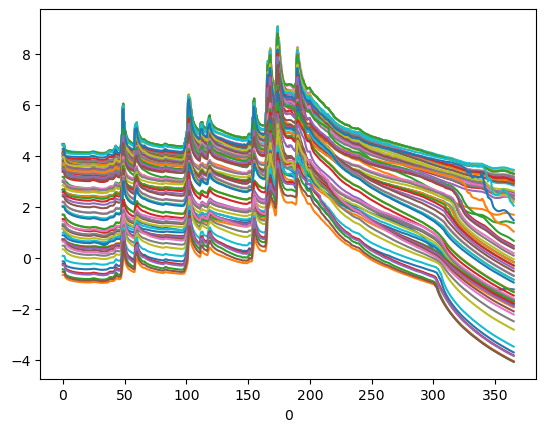

In [16]:
# pd.DataFrame(sfr_0).set_index(0).plot(legend=False)
pd.DataFrame(sfr_hd).set_index(0).plot(legend=False)

In [17]:

# Num particles 
# ParticleID, GroupNumber, Grid, Layer, Row, Column, LocalX, LocalY, LocalZ, ReleaseTime Label
# find location of all active cells for forward tracking
ibound = m.bas6.ibound.array
# adjust forward tracking start cells to focus on expected Big Springs source area
# particle should also start in layer 1 only
ibound[sfr_kij.k, sfr_kij.i, sfr_kij.j] += 1
# ibound[1:3,:] +=1
ibound[ibound<2] = 0

k_all,i_all, j_all = np.where(ibound !=0)

kij_arr = np.transpose((k_all,i_all, j_all))
kij_all = list(zip(k_all,i_all, j_all))

nodes_all = get_nodes(kij_all)
print('Cells ', len(nodes_all))

Cells  73


In [18]:
# m_dates = pd.date_range(strt_date, end_date, freq="MS")

# nnodes = m.modelgrid.nnodes



# Modpath 

In [19]:
# run shorter MODPATH simulation to reduce run time
n_days = (dt_ref.dt.max()-dt_ref.dt.min()).days # full time period
# stoptime is related to the reftime set in modpath as zero and is same in both directions
stoptime = dt_ref.time.max()- dt_ref.time.min()
print(n_days)

365


In [20]:
modelname = 'Modpath7'
exe_name = 'mpath7.exe'

tracking = 'forward'
# tracking = 'backward'

mp_ws = join(model_ws,'mp',tracking, 'mp_'+str(n_days)+'days')

mp = flopy.modpath.Modpath7(modelname= modelname, version='modpath7',exe_name= exe_name, flowmodel=m,  
                             headfilename = join(model_ws,'MF.hds'), 
                            budgetfilename = join(model_ws,'MF.cbc'), model_ws = mp_ws)

In [21]:
import shutil
shutil.copy(model_ws+'/MF.dis', mp_ws+'/MF.dis')

'F:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage/inset_oneto_denier\\mp\\forward\\mp_365days/MF.dis'

In [22]:
# new porosity variable added to zone properties based on approximate literature values
porosity = np.reshape(np.loadtxt(model_ws+'/porosity_arr.tsv', delimiter='\t'),(nlay,nrow,ncol))

In [23]:
# get times for first time step in each stress period to release particles
times_tr = dt_ref.time[1:]

# reference time represent the starting time
if tracking=='backward':
    reftime = [dt_ref.time.values[-1]]
    # get stress period that gives the end 
    spd_ref = np.min(np.where(times_tr>=reftime[0]-stoptime)) 
elif tracking =='forward':
    reftime = [dt_ref.time.values[1]]
    #     reftime = [1] # don't start in steady state
    # get stress period that start the simulation given the reference time
    spd_ref = np.min(np.where(times>=reftime[0])) 

print(reftime, spd_ref)

[0.16667867] 1


## Release time info
releasestarttime is the release time (modpath time) for starting particles in a particle group.  
*ReleaseStartTime* is a value of tracking time; therefore, it is always greater than or equal to 0.  
*Release Option*:  
1. a single release time,  
2. particles released over a period of time beginning at relase time for a length  
3. particles in a group are released at specified time values  


In [24]:
# release data from reference time (0) used by modpath
# head is measured at end of each stress period, particles should be released at same time so results are comparable
# release particles at day end that corresponds to end of stress period
releasetimes = dt_ref[dt_ref.kstp==0].time.values[1:]

# the releasedata is specified in the sloc loop
# releasedata = [len(releasedata), releasedata.tolist()]
# flopy interprets release option 2 to have length of 3 [ReleaseEventCount, specified time, release interval]
# releasedata = [len(releasetimes),  releasetimes[0], 30.4375] # interval results in year length of 365.25
# and release option to have length of 2 [ReleaseEventCount, specified times]
# releasedata = [len(releasetimes),  releasetimes] # interval results in year length of 365.25



In [25]:
# 372, 
# coded for forward tracking
spd = 0
print('Total time: ',reftime[0], 'spd ', spd+1, 'release time', reftime[0] - releasetimes[spd])


Total time:  0.16667867 spd  1 release time 0.0


In [26]:
# drape = 1 places particles in the uppermost active cell, but with modflow NWT cells do not become inactive 
# they are just set with a specified head value (e.g., -9999.9)

# need to set release layer as those identified as saturated

In [27]:
os.makedirs(mp_ws+'/sloc',exist_ok=True)
from datetime import datetime
# takes .34 seconds to write out one particle group, avg of first 10 is 0.5 seconds so 150 minutes
particlegroups = []
# useful in determing how many particles to release on a cell by cell basis
simple_particles = np.ones((nper,m.dis.nrow,m.dis.ncol)).astype(int)
for spd in np.arange(spd_ref, nper-1): #spd_ref + 1
    tic = datetime.now()
#   1 particle per cell, scale influence in post-processing
 # forward tracking uses source area
    if tracking == 'forward':
#         scale particles by recharge rate
        ij_spd = np.repeat(kij_arr, 10, axis=0)
#         ij_spd = np.repeat(bs_ij.values, simple_particles[spd, bs_ij.HRU_ROW, bs_ij.HRU_COL], axis=0)
    # backward tracking uses sink area
#     elif tracking == 'backward':
#  # repeat for 10 by 10 over cell face over 5 cell faces
# #         ij_spd = np.repeat(bs_arr.values, 10*10*5, axis=0)
#         # pull out layer, row, column to repeat for number of particles then across cells
#         ij_spd = np.repeat(np.reshape(bs_arr.values[0], (1,-1)), 10*10*len(faces[0]), axis=0)
#         for f in np.arange(1,len(faces)):
#             ij_spd = np.vstack((ij_spd, np.repeat(np.reshape(bs_arr.values[f], (1,-1)), 10*10*len(faces[f]),axis=0)))

    # compile row, column data
#     kij_all = list(zip(ij_spd[:,0],ij_spd[:,1], ij_spd[:,2]))
    # layer is defined as top layer where head > laybot
#     kij_all = list(zip(layer[spd, ij_spd[:,1], ij_spd[:,2]],ij_spd[:,1], ij_spd[:,2])) 
#     ij_spd = pd.DataFrame(ij_spd).assign(spd=spd)
    pg_spd = str(spd+1).zfill(4)
    pid = pg_spd + (pd.Series(np.arange(0,len(kij_all)).astype(str)).str.zfill(6))
    pid = pid.astype(np.int64)
    # drape is 0 means not released if 0, drape is 1 means set in next layer below
    # drape =1 can't be used for NWT because of UPW
    part1 = flopy.modpath.ParticleData(
        kij_all, drape=0, structured=True, particleids=pid,
#         localx = localx_all, localy = localy_all, localz = localz_all,
    )
    if tracking == 'forward':
        releasedata = [releasetimes[spd] - reftime[0]]
    elif tracking == 'backward':
        releasedata = [reftime[0] - releasetimes[spd]]
    pg1 = flopy.modpath.ParticleGroup(
        particlegroupname="PG_SPD"+pg_spd, particledata=part1, filename="sloc/Modpath7.pg_spd"+pg_spd+".sloc",
        releasedata = releasedata 
    )
    # list of particle groups to write
    particlegroups += [pg1]
    toc = datetime.now()
    if spd == np.round(spd, -1):
        print('SPD '+str(spd+1) +' %.3f' %((tic-toc).microseconds/1E6), end="   ")


SPD 11 0.000   SPD 21 0.000   SPD 31 0.000   SPD 41 0.999   SPD 51 0.000   SPD 61 0.999   SPD 71 0.000   SPD 81 0.000   SPD 91 0.000   SPD 101 0.000   SPD 111 0.000   SPD 121 0.000   SPD 131 0.000   SPD 141 0.000   SPD 151 0.000   SPD 161 0.000   SPD 171 0.000   SPD 181 0.984   SPD 191 0.000   SPD 201 0.000   SPD 211 0.000   SPD 221 0.000   SPD 231 0.000   SPD 241 0.000   SPD 251 0.999   SPD 261 0.000   SPD 271 0.984   SPD 281 0.000   SPD 291 0.999   SPD 301 0.999   SPD 311 0.999   SPD 321 0.000   SPD 331 0.998   SPD 341 0.999   SPD 351 0.999   SPD 361 0.999   

In [43]:
dt_ref[dt_ref.kstp==0].time.values[1:]
dt_months = dt_ref.iloc[1:].resample('MS', on='dt').first()


In [44]:
# if release particles in every cell it takes a long time to write sloc
# testing particles in layers 2-4 doesn't take as long (7k vs 35k)

'forward'

In [29]:
# default iface for MODFLOW-2005 and MODFLOW 6
defaultiface = { "RECHARGE": 6, "ET":6} #, "RECHARGE": 6, "ET": 6

tic = datetime.now()
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=porosity, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(
    mp,
    simulationtype= 'timeseries', #'timeseries', #"pathline" always fails to write
    trackingdirection=tracking,
    weaksinkoption='pass_through', #pass_through, "stop_at"
    weaksourceoption="pass_through",
#     Valid budget output options are ‘no’ - individual cell water balance errors are not computed and budget record headers 
#     are not printed, ‘summary’  - a summary of individual cell water balance errors for each time step is printed in the
#     listing file without record headers
    budgetoutputoption="summary",
#     budgetcellnumbers=[1049, 1259], #Cell numbers (zero-based) for which detailed water budgets are computed. 
    # List or tuple with two ints that define the particle group and particle id (zero-based) of the specified
    # particle that is followed in detail. 
#     traceparticledata=[1, 1000], 
#     referencetime=[0, 0, 0.0],
    referencetime=reftime, # important to start mid way in through flow model to run last 10 or 20 years
    stoptimeoption="extend", # 'total' = full run time, or 'specified' to specify stop, 'extend' is continue until termination
    stoptime = stoptime,
#     timepointdata= [dt_months.time.values.shape[0], dt_months.time.values], # try sampling points once per month
    timepointdata= [releasetimes[::7].shape[0], releasetimes[::7]], # try sampling points once per week
#     zonedataoption="on",
#     zones=zones,
    particlegroups=particlegroups,
)

# write modpath datasets
mp.write_input()

toc = datetime.now()
print((tic-toc).microseconds/1E6)
# run modpath
# mp.run_model()

0.431629


## Troubleshooting
The initial attempt had a unit 116 error which I found with modpath at shasta originally where there are too many particles for the pathline output. I will switch to timepoint tracking, weekly timepoints were enough to allow a file to write.

Still having issues getting the particles to not immediately terminate. The aquifer is generally saturated below the particles for at least the winter so it is not clear why they are terminating immediately. ET maybe?

# Scientific thoughts
## Particle tracking - Where does river recharge go?
Rather than thinking about the hyporheic zone specifically I can look at the end points of the river's recharge in terms of deep groundwater, lateral outflow, return to streamflow, storage as these help answer the questions surrounding the benefits of levee setback. Where does the water go?
## Streamflow and storage - When does river recharge provide benefit?
This is more related to the modeling effort looking at how a local levee setback provides recharge benefits. It could also be posed to the Oneto-Denier site.

If I apply the same model to the Oneto-Denier site I will have the calibration data to validate making the results more interesting.